In [1]:
import sys
import os

sys.path.append('/Users/pimpijnenburg/Desktop/Thesis/USTC_SmokeRS_dataset/code/transfer_learning/training')

In [2]:
from tl_tools import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
import pandas as pd
import numpy as np 
setup_mixed_precision()

Mixed precision policy set to: mixed_float16



In [3]:
resnet50v1_path = '/Users/pimpijnenburg/Desktop/Thesis/USTC_SmokeRS_dataset/code/transfer_learning/trained_models/resnet_50v1.keras'
resnet50 = load_model(resnet50v1_path)

2024-11-28 13:39:30.447025: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-11-28 13:39:30.447054: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2024-11-28 13:39:30.447064: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2024-11-28 13:39:30.447081: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-28 13:39:30.447091: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
test_dir = '/Users/pimpijnenburg/Desktop/Thesis/USTC_SmokeRS_dataset/data/USTC_SmokeRS/processed/test'
test_datagen = ImageDataGenerator(rescale=1./255)
test = test_datagen.flow_from_directory(test_dir, color_mode= 'rgb', batch_size = 16, shuffle= False, seed = 1, target_size=(256, 256))
X_test, y_test = test_splits(test)

Found 1245 images belonging to 6 classes.
Number of batches in the test data: 78
Batch size of a single batch 16
Number of samples in the test dataset 1245

Shape of image test set: (1245, 256, 256, 3)

Shape of label test set: (1245, 6)


In [5]:
import time

In [6]:
n_runs = 10
inference_times = list()

#Warmup pred
_ = tf.argmax(resnet50.predict(X_test), axis = 1).numpy()

for i in range(n_runs): 
    start_time = time.time()

    pred = tf.argmax(resnet50.predict(X_test), axis = 1).numpy()

    end_time = time.time()
    inference_times.append(end_time - start_time)


y_true = tf.argmax(y_test, axis=1).numpy()

2024-11-28 13:39:35.788201: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


39/39 ━━━━━━━━━━━━━━━━━━━━ 12s 260ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 205ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 206ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 206ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 207ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 206ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 203ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 204ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 208ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 205ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 202ms/step


In [7]:
avg_time = np.mean(inference_times)
std_time = np.std(inference_times)
time_per_image = avg_time / len(X_test)

print(f"Average inference time: {avg_time:.2f} ± {std_time:.2f} seconds")
print(f"Average time per image: {time_per_image*1000:.2f} milliseconds")

Average inference time: 8.04 ± 0.08 seconds
Average time per image: 6.46 milliseconds


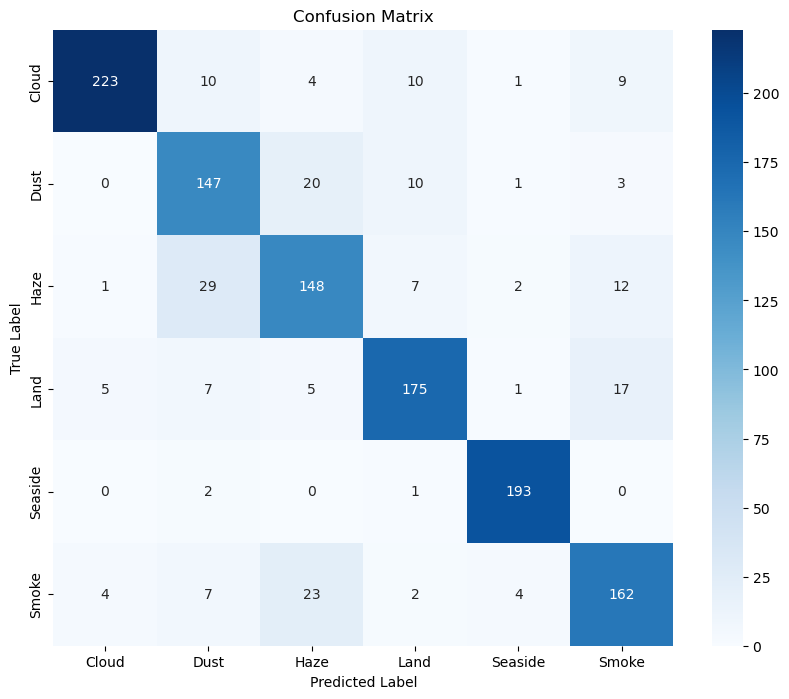

In [8]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

class_labels = list(test.class_indices.keys())
confusion_matrix = confusion_matrix(pred, y_true)


plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [9]:
y_pred_proba = resnet50.predict(X_test)

39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 203ms/step


In [10]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

n_classes = len(class_labels)
FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)
FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
TP = np.diag(confusion_matrix)
TN = confusion_matrix.sum() - (FP + FN + TP)


y_true_binary = label_binarize(y_true, classes = np.arange(n_classes))
roc_auc_scores = list()

metrics = ['Precision', 'Recall', 'F1-score', 'False Negative Rate', 'ROC-AUC']

df_metrics = pd.DataFrame(index=metrics, columns=class_labels)

for i in range(n_classes):
    df_metrics.iloc[0, i] = TP[i] / (TP[i] + FP[i])
    df_metrics.iloc[1, i] = TP[i] / (TP[i] + FN[i])
    df_metrics.iloc[2, i] = 2 * TP[i] / (2 * TP[i] + FP[i] + FN[i])
    df_metrics.iloc[3, i] = FN[i] / (FN[i] + TP[i])  # False Negative Rate
    df_metrics.iloc[4, i] = roc_auc_score(y_true_binary[:, i], y_pred_proba[:, i], average= 'weighted')
    
def round_fn(input): 
    return round(input, 2)

df_metrics = df_metrics.map(round_fn)
df_metrics

,Cloud,Dust,Haze,Land,Seaside,Smoke
Precision,0.96,0.73,0.74,0.85,0.96,0.80
Recall,0.87,0.81,0.74,0.83,0.98,0.80
F1-score,0.91,0.77,0.74,0.84,0.97,0.80
False Negative Rate,0.13,0.19,0.26,0.17,0.02,0.20
ROC-AUC,0.99,0.97,0.95,0.97,0.99,0.96


In [11]:
from sklearn.metrics import accuracy_score

print(f'Accuracy Score: {accuracy_score(pred, y_true):.2f}')
for index, row in df_metrics.iterrows(): 
    row_mean = row.mean()
    print(f'Average {index} Score: {row_mean:.2f}')

Accuracy Score: 0.84
Average Precision Score: 0.84
Average Recall Score: 0.84
Average F1-score Score: 0.84
Average False Negative Rate Score: 0.16
Average ROC-AUC Score: 0.97
